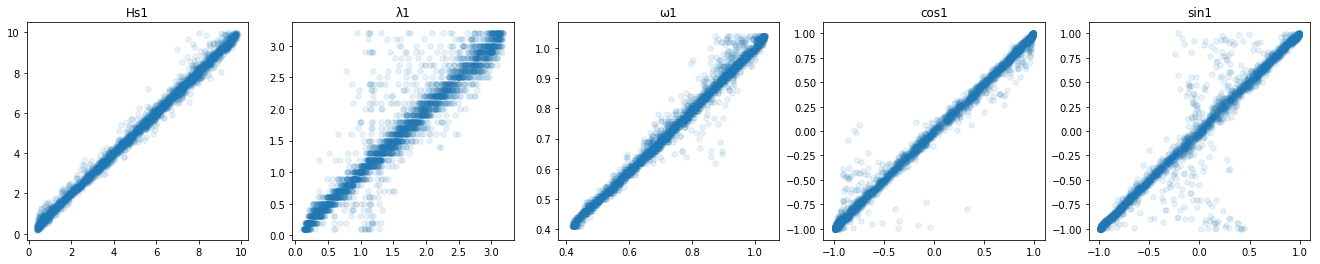

Generation: 30000. Loss = 0.024235504 ,  Test Loss = 0.026469702


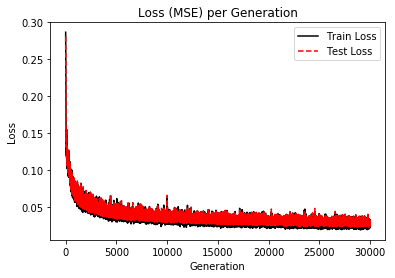

RMSE_train:0.058826298 RMSE_test:0.060767654
MAE_train:0.02450493 MAE_test:0.026469702
R_train:0.98277706 R_test:0.9814849
2962


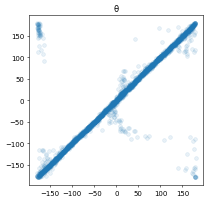

In [2]:
#from IPython.core.display import display,HTML
#display(HTML("<style>.container{width:95%!important;}</style>"))
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import math
import os
import pandas as pd
import numpy as np
from tensorflow.python.framework import ops
import matplotlib
%matplotlib inline
plt.ion()
from random import randint
import time

from ipywidgets import FloatProgress
from IPython.display import display, clear_output
#csvファイルの読み込み
inputdata = pd.read_csv('remake_1.csv', encoding='shift_jis')
a_df = inputdata.values
#入力変数と出力変数の指定
x_vals = np.array([x[0:816] for x in a_df])
y_vals = np.array([x[816:821] for x in a_df])

#defaultとして設定されているグラフをリセット
ops.reset_default_graph()

#変数を用いるためのセッションを用意
sess = tf.Session()

#バッチサイズの設定
batch_size = 512
 
#結果を再現可能にするためのランダムシードを作成
seed = 15
np.random.seed(seed)
tf.set_random_seed(seed)

#正規化の定義
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max-col_min) 

#データの最大値と最小値を保存
col_max0 = y_vals.max(axis=0)
col_min0 = y_vals.min(axis=0) 


#正規化の実行
x_vals0 = np.nan_to_num(normalize_cols(x_vals))
y_vals0 = np.nan_to_num(normalize_cols(y_vals))

#訓練データとテストデータを8：2に分割
train_indices = np.random.choice(len(x_vals0), round(len(x_vals0)*0.8), replace=False) 
test_indices = np.array(list(set(range(len(x_vals0))) - set(train_indices))) 
test_indices1 = np.array(list(set(range(len(x_vals0))) - set(train_indices)))
x_vals_train = x_vals0[train_indices] 
x_vals_test = x_vals0[test_indices] 
y_vals_train = y_vals0[train_indices] 
y_vals_test = y_vals0[test_indices] #正規化した正解値、θもある
y_vals_test1 = y_vals[test_indices1]#正解値


#プレースホルダーの作成
x_data = tf.placeholder(dtype=tf.float32)
y_target = tf.placeholder(dtype=tf.float32)
keep_prob = tf.placeholder(tf.float32)


#中間層ノードの指定、dropout層の挿入
hidden_layer_nodes  = 120
hidden_layer_nodes2 = 80
hidden_layer_nodes3 = 50
hidden_layer_nodes4 = 25
A1 = tf.Variable(tf.random_normal(shape=[816, hidden_layer_nodes]))  #*np.sqrt(1/816)
b1 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes]))  #*np.sqrt(1/816)
#drop = tf.nn.dropout(A1, keep_prob)
A2 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes, hidden_layer_nodes2])*np.sqrt(2/hidden_layer_nodes))  
b2 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes2])*np.sqrt(2/hidden_layer_nodes))  
#drop = tf.nn.dropout(A2, keep_prob)
A3 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes2, hidden_layer_nodes3])*np.sqrt(2/hidden_layer_nodes2))  
b3 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes3])*np.sqrt(2/hidden_layer_nodes2))   
A4 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes3, hidden_layer_nodes4])*np.sqrt(1/hidden_layer_nodes3))  
b4 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes4])*np.sqrt(1/hidden_layer_nodes3))  
#drop = tf.nn.dropout(A3, keep_prob)
A5 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes4, 5])*np.sqrt(1/hidden_layer_nodes4))  
b5 = tf.Variable(tf.random_normal(shape=[5])*np.sqrt(1/hidden_layer_nodes4)) 
#drop = tf.nn.dropout(A4, keep_prob)


#活性化関数の適用
hidden_output = tf.nn.sigmoid(tf.add(tf.matmul(x_data, A1), b1))
hidden_output2 = tf.nn.relu(tf.add(tf.matmul(hidden_output, A2), b2))
hidden_output3 = tf.nn.relu(tf.add(tf.matmul(hidden_output2, A3), b3))
hidden_output4 = tf.nn.sigmoid(tf.add(tf.matmul(hidden_output3, A4), b4))
final_output = tf.nn.sigmoid(tf.add(tf.matmul(hidden_output4, A5), b5))
final_output1 = (final_output*(col_max0 - col_min0) + col_min0)

#損失関数
loss = tf.reduce_mean(tf.abs(final_output - y_target))

#勾配降下法と最適化
my_opt = tf.train.AdamOptimizer(0.005)
train_step = my_opt.minimize(loss)


#変数の初期化
init = tf.global_variables_initializer()
sess.run(init)

#RMSE
RMSE = tf.sqrt(tf.reduce_mean(tf.square(final_output-y_target)))
#MAE
MAE = tf.reduce_mean(tf.abs(final_output-y_target))
#相関係数
R = tf.reduce_mean((final_output-tf.reduce_mean(final_output))*(y_target-tf.reduce_mean(y_target))) / (tf.sqrt(tf.reduce_mean(tf.square(final_output-tf.reduce_mean(final_output))))*tf.sqrt(tf.reduce_mean(tf.square(y_target-tf.reduce_mean(y_target)))))


#訓練開始
loss_vec = []
test_loss = []
train_acc = []
test_acc = []

siz = 10
dat = np.zeros((siz, siz))
fig, (axe_H,axe_lambda, axe_w,axe_cos,axe_sin) = plt.subplots(ncols=5, figsize=(15,5))
#fig = plt.figure()
#axe_H,axe_w = fig.add_subplot(111)
#axe_w = fig.add_subplot(111)

for i in range(30000):
                
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = y_vals_train[rand_index]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y , keep_prob:0.5})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    test_temp_loss = sess.run(loss, feed_dict={x_data: x_vals_test, y_target: [y_vals_test]})
    test_loss.append(test_temp_loss)

    temp_acc_train2 = sess.run(RMSE, feed_dict={x_data: x_vals_train, y_target: [y_vals_train]})
    train_acc.append(temp_acc_train2)
    temp_acc_test2 = sess.run(RMSE, feed_dict={x_data: x_vals_test, y_target: [y_vals_test]})
    test_acc.append(temp_acc_test2)
    
    temp_acc_train3 = sess.run(MAE, feed_dict={x_data: x_vals_train, y_target: [y_vals_train]})
    train_acc.append(temp_acc_train3)
    temp_acc_test3 = sess.run(MAE, feed_dict={x_data: x_vals_test, y_target: [y_vals_test]})
    test_acc.append(temp_acc_test3)
    
    temp_acc_train5 = sess.run(R, feed_dict={x_data: x_vals_train, y_target: [y_vals_train]})
    train_acc.append(temp_acc_train5)
    temp_acc_test5 = sess.run(R, feed_dict={x_data: x_vals_test, y_target: [y_vals_test]})
    test_acc.append(temp_acc_test5)
    if (i+1) % 100 == 0:
        clear_output(wait = True)
        #axe_loss.plot(loss_vec, 'k-', label='Train Loss')
        #axe_loss.plot(test_loss, 'r--', label='Test Loss')
        axe_H.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,0:1],y_vals_test1[:,0:1],s=30, alpha=0.1)
        axe_H.set_title('Hs1')
        axe_w.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,4:5],y_vals_test1[:,4:5],s=30, alpha=0.1)
        axe_w.set_title('ω1')
        axe_cos.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,1:2],y_vals_test1[:,1:2],s=30, alpha=0.1)
        axe_cos.set_title('cos1')
        axe_sin.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,2:3],y_vals_test1[:,2:3],s=30, alpha=0.1)
        axe_sin.set_title('sin1')
        axe_lambda.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,3:4],y_vals_test1[:,3:4],s=30, alpha=0.1)
        axe_lambda.set_title('λ1')
        fig.set_size_inches(23,4)
        display(fig)
        #time.sleep(.2)
        #axe_loss.cla()
        axe_H.cla()
        axe_w.cla()
        axe_cos.cla()
        axe_sin.cla()
        axe_lambda.cla()
        
          
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss)+" ,  Test Loss = "+str(test_temp_loss))
        plt.close()

        #グラフをプロット
        plt.plot(loss_vec, 'k-', label='Train Loss')
        plt.plot(test_loss, 'r--', label='Test Loss')
        plt.title('Loss (MSE) per Generation')
        plt.legend(loc='upper right')
        plt.xlabel('Generation')
        plt.ylabel('Loss')
        plt.show()


#精度の表示
print('RMSE_train:' + str(temp_acc_train2) + ' ' + 'RMSE_test:' + str(temp_acc_test2))
print('MAE_train:' + str(temp_acc_train3) + ' ' + 'MAE_test:' + str(temp_acc_test3))
print('R_train:' + str(temp_acc_train5) + ' ' + 'R_test:' + str(temp_acc_test5))

#正規化されて推定された出力値の表示[InternetShortcut]

C = sess.run(final_output, feed_dict={x_data: x_vals_test, y_target: y_vals_test})

#元のスケールに合わせて推定された出力値の表示
D = sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})

print(len(D[:,4:5]))
D_kaku=np.zeros(len(D[:,4:5]))
y_val_kaku=np.zeros(len(D[:,4:5]))
for i in range(len(D[:,4:5])):
    D_kaku[i]=math.atan2(D[i][2:3],D[i][1:2])*180/np.pi
    y_val_kaku[i]=math.atan2(y_vals_test1[i][2:3],y_vals_test1[i][1:2])*180/np.pi

plt.figure(figsize=(4.5,4.5),dpi=50)
plt.scatter(D_kaku,y_val_kaku,s=30, alpha=0.1)
plt.title('θ')
plt.show()

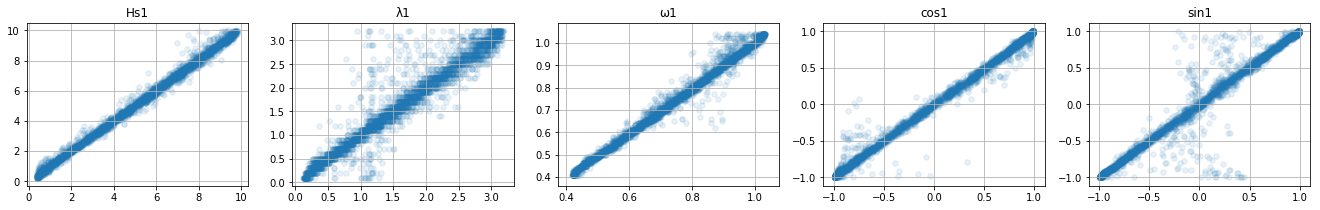

In [15]:
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:95%!important;}</style>"))
y_vals_train1=y_vals[train_indices]
axe_H.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,0:1],y_vals_test1[:,0:1],s=30, alpha=0.1)
axe_H.grid()
axe_H.set_title('Hs1')
axe_w.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,4:5],y_vals_test1[:,4:5],s=30, alpha=0.1)
axe_w.grid()
axe_w.set_title('ω1')
axe_cos.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,1:2],y_vals_test1[:,1:2],s=30, alpha=0.1)
axe_cos.grid()
axe_cos.set_title('cos1')
axe_sin.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,2:3],y_vals_test1[:,2:3],s=30, alpha=0.1)
axe_sin.grid()
axe_sin.set_title('sin1')
axe_lambda.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,3:4],y_vals_test1[:,3:4],s=30, alpha=0.1)
axe_lambda.grid()
axe_lambda.set_title('λ1')
fig.set_size_inches(23,3)
display(fig)
#time.sleep(.2)
#axe_loss.cla()
#axe_H.grid()
axe_H.cla()
axe_w.cla()
axe_cos.cla()
axe_sin.cla()
axe_lambda.cla()

2962


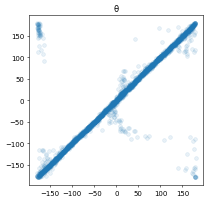

In [7]:
print(len(D[:,4:5]))
D_kaku=np.zeros(len(D[:,4:5]))
y_val_kaku=np.zeros(len(D[:,4:5]))
for i in range(len(D[:,4:5])):
    D_kaku[i]=math.atan2(D[i][2:3],D[i][1:2])*180/np.pi
    y_val_kaku[i]=math.atan2(y_vals_test1[i][2:3],y_vals_test1[i][1:2])*180/np.pi

plt.figure(figsize=(4.5,4.5),dpi=50)
plt.scatter(D_kaku,y_val_kaku,s=30, alpha=0.1)
plt.title('θ')
plt.show()

In [10]:
retsu=4
R = tf.reduce_mean((final_output[:,retsu:retsu+1]-tf.reduce_mean(final_output[:,retsu:retsu+1]))*(y_target[:,retsu:retsu+1]-tf.reduce_mean(y_target[:,retsu:retsu+1]))) / (tf.sqrt(tf.reduce_mean(tf.square(final_output[:,retsu:retsu+1]-tf.reduce_mean(final_output[:,retsu:retsu+1]))))*tf.sqrt(tf.reduce_mean(tf.square(y_target[:,retsu:retsu+1]-tf.reduce_mean(y_target[:,retsu:retsu+1])))))
#RMSE
RMSE = tf.sqrt(tf.reduce_mean(tf.square(final_output[:,retsu:retsu+1]-y_target[:,retsu:retsu+1])))
#MAE
MAE = tf.reduce_mean(tf.abs(final_output[:,retsu:retsu+1]-y_target[:,retsu:retsu+1])) 

temp_acc_test21 = sess.run(RMSE, feed_dict={x_data: x_vals_test, y_target: y_vals_test})
temp_acc_test31 = sess.run(MAE, feed_dict={x_data: x_vals_test, y_target:y_vals_test})
temp_acc_test41 = sess.run(R, feed_dict={x_data: x_vals_test, y_target: y_vals_test})

print("RMSE: "+str(temp_acc_test21))
print("MAE: "+str(temp_acc_test31))
print("R: "+str(temp_acc_test41))

RMSE: 0.038739406
MAE: 0.022568252
R: 0.9912683


In [11]:
#print(np.mean(C[:,3:4]))
theta1_mean=math.atan2(np.mean(D[:,4:5]),np.mean(D[:,3:4]))  #rad
theta2_mean=math.atan2(np.mean(y_vals_test1[:,4:5]),np.mean(y_vals_test1[:,3:4]))

Sxy, Sxx, Syy=0,0,0
for i in range(len(D[:,4:5])-1):
    for j in range(i+1,len(D[:,4:5])):
        Sxy +=math.sin(math.atan2(D[i][4:5],D[i][3:4])-math.atan2(D[j][4:5],D[j][3:4]))*math.sin(math.atan2(y_vals_test1[i][4:5],y_vals_test1[i][3:4])-math.atan2(y_vals_test1[j][4:5],y_vals_test1[j][3:4]))
        Sxx += math.sin(math.atan2(D[i][4:5],D[i][3:4])-math.atan2(D[j][4:5],D[j][3:4]))**2
        Syy += math.sin(math.atan2(y_vals_test1[i][4:5],y_vals_test1[i][3:4])-math.atan2(y_vals_test1[j][4:5],y_vals_test1[j][3:4]))**2
    
Rc=Sxy/(math.sqrt(Sxx*Syy))
print(Rc)

0.9548765393166085


In [13]:
np.savetxt("NN4Layer_prediction.csv",D)
np.savetxt("NN4Layer_target.csv",y_vals_test1)

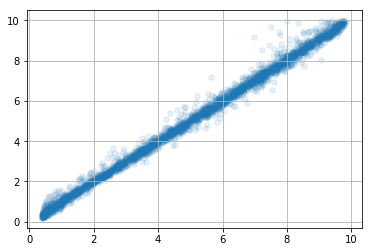

<Figure size 720x720 with 0 Axes>

In [23]:
plt.scatter(sess.run(final_output1, feed_dict={x_data: x_vals_test, y_target: y_vals_test1})[:,0:1],y_vals_test1[:,0:1],s=30, alpha=0.1)
plt.grid()
plt.figure(figsize=(10,10))
plt.show()